Import all the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100) # let dataframes expand out all columns

Define a couple functions to create dummy variables for the subcategories. Shouldn't need to worry about these too much, they just put 1's under the columns of the subcategories the project falls under and 0's in the columns the project is not classified as.

In [2]:
def splitSubcat(df):
    df = df.copy()
    ext = [np.nan, np.nan]
    results = []
    for row in df['subcat_tree'].iteritems():
        if type(row[1]) is str:
            if ',' in row[1]:
                ext = list(map(lambda x: x.strip(), row[1].split(',')))
            else:
                ext[0] = row[1].strip()
                ext[1] = np.nan

            results.append([ext[0], ext[1]])
        else:
            results.append([np.nan, np.nan])
        
    results = pd.DataFrame(results, columns=['subcat_first', 'subcat_second'], index=df.index)
    print('Finished Splitting...')
    return df.merge(results, right_index=True, left_index=True).drop('subcat_tree', axis=1)

def sumSubcats(df, columns):
    df = df.copy()
    df2 = pd.get_dummies(df, prefix='s', columns=columns)
    cols, col_counts = np.unique(df2.columns.values, return_counts=True)
    for i, col in enumerate(cols):
        if col_counts[i] == 1:
            df[col] = df2[col]
        elif col_counts[i] > 1:
            df[col] = df2[col].sum(axis=1)
    return df

Import all the datasets.

In [3]:
schools_dat = pd.read_csv('data/data_clean/schools_clean.csv')
teachers_dat = pd.read_csv('data/data_clean/teachers_clean.csv')
resources_dat = pd.read_csv('data/data_clean/resources_clean.csv')
projects_notext_dat = pd.read_csv('data/data_clean/projects_num_clean.csv')

Take a random sample of $n=10000$ from the projects dataset. Merge this with schools, aligning `school_id`. Get rid of a few columns we don't care about (for the time being). Then create the dummy variables using the functions above.

In [4]:
sample = projects_notext_dat.sample(10000)
merge = sample.merge(teachers_dat, on='teacher_id').merge(schools_dat, on='school_id')
end = merge.drop(['proj_post_seq', 'proj_type', 'funded', 'posted', 'expire', 'first_project_posted', 'school_zip'], axis=1)

In [5]:
cat_break = sumSubcats(splitSubcat(end), ['subcat_first', 'subcat_second'])

Finished Splitting...


Basically, clean the dataset so it's only 1's and 0's which we can compare. More info inline.

In [6]:
num_mat = cat_break.select_dtypes(np.number) # use only the numerical columns

num_mat = num_mat[num_mat['prefix'] > 0] # limit teacher prefix to only Mrs. and Mr.
num_mat['prefix'] = num_mat['prefix'] - 1 # reduce teacher prefix to only 1's and 0's

# we'll create four sets of dummy variables
metros = []
grades = []
costs = []
lunches = []

num_mat.dropna(inplace=True) # get rid of rows that have one or more null values

for i, row in num_mat.iterrows():
    
    # iterate over each row in the subset thus far, we'll create dummy variables for each select feature
    
    # expand metropolitan type
    res = [0, 0, 0, 0, 0]
    if row['metro_type'] == 1:
        res[0] = 1 # rural
    elif row['metro_type'] == 2:
        res[1] = 1 # suburban
    elif row['metro_type'] == 3:
        res[2] = 1 # urban
    elif row['metro_type'] == 4:
        res[3] = 1 # town
    elif row['metro_type'] == 0:
        res[4] = 1 # ambiguous
        
    metros.append(np.array(res))
    
    # expand grade level
    res = [0, 0, 0, 0]
    if row['grade_level'] == 2:
        res[0] = 1
    elif row['grade_level'] == 3:
        res[1] = 1
    elif row['grade_level'] == 6:
        res[2] = 1
    elif row['grade_level'] == 9:
        res[3] = 1
        
    grades.append(np.array(res))
    
    # expand and bin the cost of the project
    res = [0, 0, 0, 0, 0, 0]
    if row['cost'] < 250:
        res[0] = 1
    elif row['cost'] < 500:
        res[1] = 1
    elif row['cost'] < 750:
        res[2] = 1
    elif row['cost'] < 1000:
        res[3] = 1
    elif row['cost'] < 1250:
        res[4] = 1
    elif row['cost'] >= 1250:
        res[5] = 1
        
    costs.append(np.array(res))
    
    # expand and bin the portion of students getting free lunch
    res = [0, 0, 0, 0]
    if row['free_lunch'] < 25:
        res[0] = 1
    elif row['free_lunch'] < 50:
        res[1] = 1
    elif row['free_lunch'] < 75:
        res[2] = 1
    elif row['free_lunch'] <= 100:
        res[3] = 1
        
    lunches.append(np.array(res))
        
# merge all these dummy variables into the original matrix and get rid of the original columns
metros = pd.DataFrame(metros, columns=['rural', 'suburban', 'urban', 'town', 'ambiguous_metro'], index=num_mat.index)
grades = pd.DataFrame(grades, columns=['grade2', 'grade3', 'grade6', 'grade9'], index=num_mat.index)
costs = pd.DataFrame(costs, columns=['cost250', 'cost500', 'cost750', 'cost1000', 'cost1250', 'cost1250g'], index=num_mat.index)
lunches = pd.DataFrame(lunches, columns=['lunch25', 'lunch50', 'lunch75', 'lunch100'], index=num_mat.index)

num_mat = num_mat.merge(metros, left_index=True, right_index=True).drop('metro_type', axis=1)
num_mat = num_mat.merge(grades, left_index=True, right_index=True).drop('grade_level', axis=1)
num_mat = num_mat.merge(costs, left_index=True, right_index=True).drop('cost', axis=1)
num_mat = num_mat.merge(lunches, left_index=True, right_index=True).drop('free_lunch', axis=1)


print(num_mat.shape) # size of the matrix
num_mat.sample(5) # randoly sample 5

(6181, 51)


,status,prefix,s_Applied Sciences,s_Care & Hunger,s_Character Education,s_Civics & Government,s_College & Career Prep,s_Community Service,s_ESL,s_Early Development,s_Economics,s_Environmental Science,s_Extracurricular,s_Financial Literacy,s_Foreign Languages,s_Gym & Fitness,s_Health & Life Science,s_Health & Wellness,s_History & Geography,s_Literacy,s_Literature & Writing,s_Mathematics,s_Music,s_Nutrition Education,s_Other,s_Parent Involvement,s_Performing Arts,s_Social Sciences,s_Special Needs,s_Team Sports,s_Visual Arts,s_Warmth,rural,suburban,urban,town,ambiguous_metro,grade2,grade3,grade6,grade9,cost250,cost500,cost750,cost1000,cost1250,cost1250g,lunch25,lunch50,lunch75,lunch100
8599,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
5304,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
818,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
7107,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
7496,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0


Compute a distance matrix. Every entry is the distance from the ith to the jth element. Subset the matrix to include only the ij-th entry, not the ji-th.

In [7]:
from scipy.spatial.distance import cdist

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
# https://stats.stackexchange.com/questions/55798/what-is-the-optimal-distance-function-for-individuals-when-attributes-are-nomina/55802#55802
# https://en.wikipedia.org/wiki/Jaccard_index
# http://www.iiisci.org/journal/CV$/sci/pdfs/GS315JG.pdf
# https://www.umass.edu/landeco/teaching/multivariate/readings/McCune.and.Grace.2002.chapter6.pdf

Y = cdist(num_mat, num_mat, 'cosine')

print('Similarities cast...')

low = np.tril_indices(Y.shape[0], -1) # Remove the bottom triangular
Y[low[0], low[1]] = np.nan

Similarities cast...


Sample the first 100 projects and visualize their similarity. 0 is completely similar, 1 is completely dissimilar.

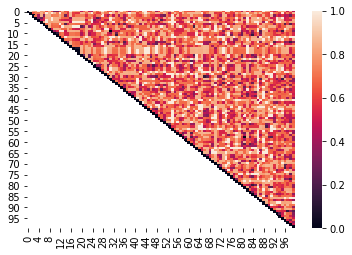

In [8]:
sns.heatmap(Y[:100, :100])

Extract the most similar other project for $j\geq i$.

In [9]:
# variable equal to the 1st column of Y, excluding the last row, sorted within row
top_similarities = Y[:-1].argsort(axis=1)[:, 1]

In [11]:
ds = []
indices = []

for i, j in enumerate(top_similarities):
    ds.append(Y[i, j])
    
    ixs = num_mat.iloc[[i, j], :].index
    indices.append(ixs)
    
    if i < 2:
        print('distance: {}\t({},{})'.format(Y[i, j], i, j))
        print(cat_break.loc[ixs])
    break

print('Mean Cosine similarity coefficient of nearest neighbors: {:.3f}'.format(np.array(ds).mean()))

distance: 0.0871290708247231	(0,610)
                            project_id                         school_id  \
2     ba7efd59704c31b47292539ca06b5b4e  5c89b12f510bf40a2c5286624cab03f8   
1011  ddc13badf1f4dede31cdbcc077b60689  65aab4a1c032f775b7b8f0638bcd6443   

                            teacher_id        cat_tree  grade_level  \
2     4a98f2bd252c1b595641bafe034586b7  Math & Science            2   
1011  a4d39ed59be6e8a2bd67408f508d519f  Math & Science            2   

     resource_cat    cost  status  prefix                     school_name  \
2        Supplies  535.62       0       1  Elmer H Cook Elementary School   
1011     Supplies  542.72       1       1         Cowan Elementary School   

      metro_type  free_lunch school_state school_city school_county  \
2              3        41.0     Arkansas  Fort Smith     Sebastian   
1011           3        37.0      Indiana      Muncie      Delaware   

               school_district subcat_first subcat_second  s_Applied Scien